Elsa McDowell

CSPB 3202- Artificial Intelligence

Fall 2023

# Introduction

For this assignment, I will be developing a Convolutional neural network (CNN) model that can be used to determine if tumor cells are present in an image file.


I will be using the Histopathologic Cancer Detection dataset from Kaggle.com (https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) to train and test my model. This dataset contains pathology images. The model needs to determine if the center region of a patch contains at least one pixel of tumor cell and classify the images accordinly (0 if there are no tumor cells present and 1 if there are tumor cells present).

The first step of this procces is to download the dataset from Kaggle:

In [ ]:
# get data from kaggle

# make kaggle directory
! mkdir ~/.kaggle

# copy kaggle json to directory
! cp kaggle.json ~/.kaggle/

# change permissions for kaggle json so it can be used
! chmod 600 ~/.kaggle/kaggle.json

# download dataset
! kaggle competitions download histopathologic-cancer-detection

# unzip the dataset
from zipfile import ZipFile

# open zip file
with ZipFile("histopathologic-cancer-detection.zip", 'r') as zip:

# extract files
  zip.extractall("histopathologic-cancer-detection-data")

100% 6.31G/6.31G [01:16<00:00, 125MB/s]
100% 6.31G/6.31G [01:16<00:00, 88.0MB/s]


## Set up the Python environment to support machine learing and data visualizaion

Next, I need to import the Keras library and others that are needed to process the image and develop the model. I am using the Keras library because it's a reasonably user friendly API for building and training neural networks and is compatible with TensorFlow (which I will also be using to build and train my models)

I am also importing the matplotlib and seaborn libraries so that I can visualize some of my data. These vizualizations will help me analyze the data and evaluate my models.

In [ ]:
# import python libraries

import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop, Adagrad

# set seaborn chart style
sns.set(style="dark", palette="colorblind")
sns.set_context("notebook",rc={"lines.linewidth": 2.5})

# Exploratory Data Analysis (EDA)

After extracting the dataset from the Kaggle zip file, the data is divided into a test directory and a train directory. Both of the these directories contain a number of .tif format image files. There is also a sample_submission.csv that will be needed to create the file I submit to Kaggle. Finally, there is train_labels.csv that contains the image ids from the train directory along with their label (0: image does not contain tumor cells or 1: image contains tumor cells)

The images in the train directory will be used in combination with the information in tran_labels.csv to develop my model. This model will then be used to evaluate the files in the test directory

In [ ]:
# get data into usable format

# store test and train directories as variables
test_dir = "./histopathologic-cancer-detection-data/test/"
train_dir = "./histopathologic-cancer-detection-data/train"

# read trainingcsv files into dataframes
train_labels = pd.read_csv("./histopathologic-cancer-detection-data/train_labels.csv")

# copy the training labels df so it can be modified with image file extension
images_train = train_labels.copy()

# add an id column to the new df update the values to be the id + .tif
images_train['id'] = train_labels['id'] + '.tif'

# convert label column in images_train to type string
images_train['label'] = images_train['label'].astype(str)

# create a dataframe for the test images
images_test = pd.DataFrame({'id':os.listdir(test_dir)})


### EDA continued

Now that the data is in dataframes, I want to take a look at its size, shape, and other characteristics. I also want to check for null values, since they might need to be cleaned from the dataset.

In [ ]:
# examine train_labels df
print(train_labels.shape, end =' \n\n')
print(train_labels.head(), end = '\n\n')
print(train_labels.info(), end = '\n\n')
print(train_labels.value_counts("label"),end = '\n\n')
print(train_labels.isnull().sum())

(220025, 2) 

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None

label
0    130908
1     89117
dtype: int64

id       0
label    0
dtype: int64


In [ ]:
# examine images_train df
print(images_train.shape, end =' \n\n')
print(images_train.head(), end = '\n\n')
print(images_train.info(), end = '\n\n')
print(images_train.value_counts("label"),end = '\n\n')
print(images_train.isnull().sum())

(220025, 2) 

                                             id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB
None

label
0    130908
1     89117
dtype: int64

id       0
label    0
dtype: int64


In [ ]:
# take a look at the date in images_test df
print(images_test.shape, end =' \n\n')
print(images_test.head(), end = '\n\n')
print(images_test.info(), end = '\n\n')
print(images_test.isnull().sum())

(57458, 1) 

                                             id
0  b46e7dcf563b00a7d4d7ed91143378c4f183a639.tif
1  f50e54bfefef71c2e03332b45a7f34e1c67d7cac.tif
2  90a96a45e205e3d1ced22627f0b752898d00956b.tif
3  46ceb05341f74d6c01ce5d8dbd4cf28724137032.tif
4  8e3f127a3c8f0789a4c9dc8bdd0f87ca625ad55b.tif

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
dtypes: object(1)
memory usage: 449.0+ KB
None

id    0
dtype: int64


### Input data summary

It appears that the training dataset contains 220025 image files. The dataframe has 2 columns: one for the filename and one for the label value. Of training files, 130908 have label 0, indicating that they do not contain a tumor cell. The other 89117 files have label 1, indicating that they do contain tumor cells.

The test dataset, as is expected, does not yet have any files that have been identified as having tumor cells. The test_images dataframe actually only contains the file names (ids) themselves, so I will need to modify it later to add the labels when my model is applied to the test data.

Neither the the training or testing datasets have any null values, so there is no need to do any cleaning to remove or otherwise account for nulls.

At this point, it would be helpful to do some data visualiztions to futher examine the training dataset in more detail.

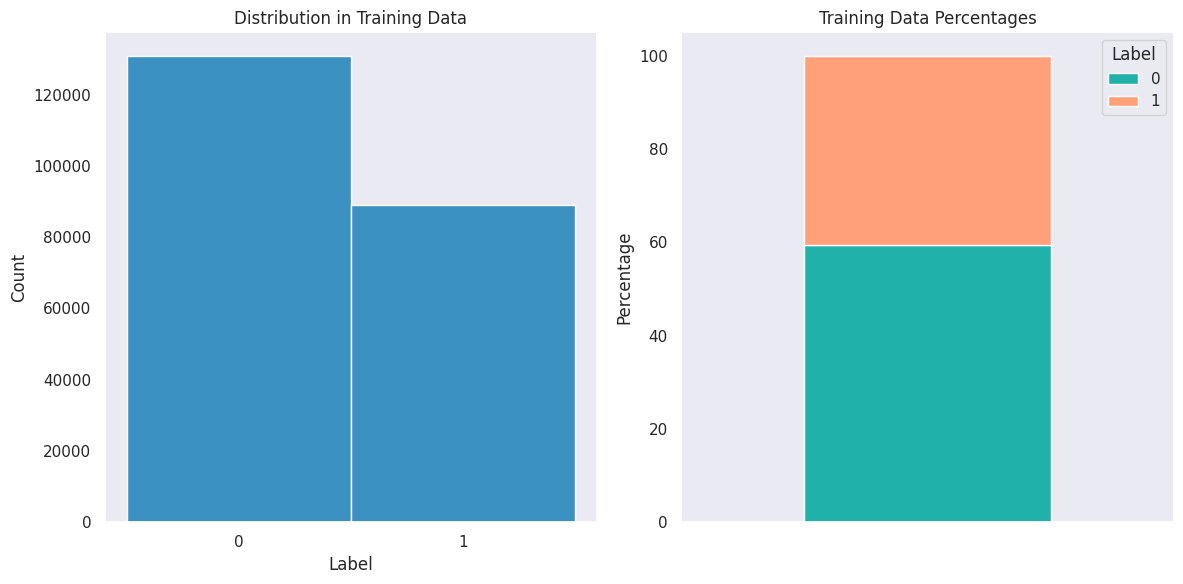

In [ ]:
# visualize the distribution of the training dataset
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# histogram
sns.histplot(data=train_labels, x='label', bins=2, ax=axes[0])
axes[0].set_title('Distribution in Training Data')
axes[0].set_xlabel('Label')
axes[0].set_xticks(ticks=[0.25, 0.75])
axes[0].set_xticklabels(labels=[0, 1])

# Stacked bar chart w/%
label_counts = train_labels['label'].value_counts()
total = label_counts.sum()
percentages = label_counts / total * 100
plot_df = pd.DataFrame({'0': [percentages.get(0, 0)], '1': [percentages.get(1, 0)]})
plot_df.plot(kind = 'bar', stacked = True, ax = axes[1], color = ['lightseagreen', 'lightsalmon'])
axes[1].set_title('Training Data Percentages')
axes[1].set_ylabel('Percentage')
axes[1].legend(title='Label')
axes[1].set_xticks([])  # Remove x-axis ticks

# Show the plots
plt.tight_layout()
plt.show()

I created 2 visualizations. The first is a histogram that shows how many images in the training dataset have each label. The second is a stacked bar chart that shows the percentage of the dataset that falls into each category. It appears that approximatly 60% of the training dataset is negative (no tumor) images, while the other 40% is positive (tumor present) images. Given the size of the dataset, this shows me that it should be fine to use an 80/20 train validation split without having to worry that there aren't enough positive or negative cases in either the train or validate portions.

It might also be helpful to have an understanding of what the image files actually look like. I will pull a random set of images from the training data to display along with their label value:

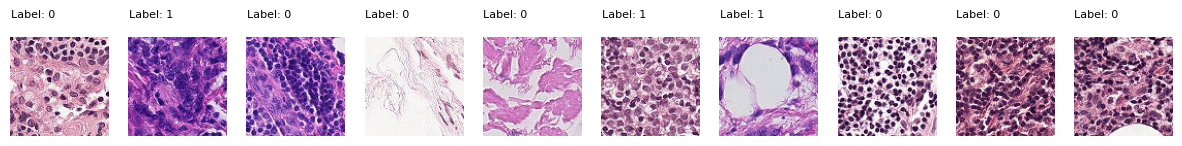

In [ ]:
# Get a random sample of images
num = 10
random_idx = random.sample(range(len(images_train)), num)
sample_images = images_train.iloc[random_idx]

plt.figure(figsize=(15, 10))

for idx, (_, row) in enumerate(sample_images.iterrows()):
    image_path = os.path.join(train_dir, row['id'])
    image = Image.open(image_path)

    plt.subplot(1, num, idx + 1)
    plt.imshow(image)
    plt.axis('off')

    # Add label value as text
    label = row['label']
    plt.text(0, -20, f'Label: {label}', color='black', fontsize=8)

plt.show()

This set of samples has images with tumor cells and without, but without the labels, I wouldn't be able to tell which images were which. Still, it's interesting to see raw data that my model will be using as an input. There seems to be a fair amount of variation in the images- some are densely populated and some are more sparse. This may factor into decisions about what layers are added (or not) to the model.

### Developing a model

I'm now ready to begin building and training my CNN model Before getting to the model itself, the training dataset needs to be split into train and validaion portions.

The training data is used to train the model. The validaion data is then used to evaluate how the model performs on data that wasn't used for training. The train/validate split will allow me to examine the effect of tuning my model's hyperparamters and helps avoid overfitting (overfit models perform well on the data that was used to train them, but don't generalize well to unseen data and therefore don't have good predictive power). I will be using an 80/20 split of the training data (80% of the dataset will be used to train the model and the remaining 20% will be used to validate that the model generalizes well and will likely be predictive when used for the test data).

To start with, I picked a batch value on the higher end to force faster convergence while I'm doing my inital model evaluation. It's likely that this value will be tuned later to a more optimal value.

In [ ]:
# split training data into traing and validation
generator = ImageDataGenerator(rescale=1./255, validation_split=0.20)
batch_size = 200

# genertate training data
data_train = generator.flow_from_dataframe(
    directory = train_dir,
    dataframe = images_train,
    subset ='training',
    x_col ='id',
    y_col ='label',
    class_mode ='binary',
    batch_size = batch_size,
    target_size = (64, 64))

# generate validation data
data_validate=generator.flow_from_dataframe(
    directory = train_dir,
    dataframe = images_train,
    subset ='validation',
    x_col ='id',
    y_col ='label',
    class_mode ='binary',
    batch_size = batch_size,
    target_size = (64, 64))

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


I started with a fairly simple model, using the model we saw for the fashion MNIST example we studied in class as a starting point. I did make some modifications to this model though. It's still a sequential model with a linear stack of layers, but I added a Flatten layer to flatten the data into a 1D array (as the other layers require). I then used 2 Dense layers.

The first Dense layer uses Rectified Linear Activation (relu) as part of a hidden layer to learn patterns and reationships in the training data. I chose a medium sized number of neurons (256) rather than a higher or lower value (such as 64 or 512) to try to balance the computational complexity and learning ability at this stage of model development.

The second Dense layer uses sigmoid activation as opposed to softmax. This is because this problem is a binary classificaion problem and sigmoid is correct choice for that (softmax should be used when there are multiple possible classifications).

I also wanted to investigte which optimizter method was most appropriate for this dataset. I selected the SGD, Adam, RMSprop and Adagrad optimizers as the ones I wanted to compare. In an scenario with more computational power available, I might have compared addtional optimizer methods, but these 4 seemed like likey canidates to perform well on this data without adding unncessary complexity.

I set the learning rate to 0.001 for all 4 iterations, since as with the other hyperparmeters, I wanted to keep everything exept the optimizer the same, try to have a starting value that was not too small or too large for convergence to reasonably quickly.

My first step of model evaluation was to run my basic model using each of my selected optimizers for 5 epochs and compare their accuracy:

In [ ]:
# build basic sigmoid model- using sigmoid instead of softmax because it's the correct choice when there are only 2 categories
# with optimizer: SGD
SGD_model_basic = Sequential()

SGD_model_basic.add(Flatten())
SGD_model_basic.add(Dense(units = 256, activation = 'relu'))
SGD_model_basic.add(Dense(units = 1, activation = 'sigmoid'))

SGD_model_basic.build(input_shape = (batch_size, 64, 64, 3))
SGD_model_basic.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (200, 12288)              0         
                                                                 
 dense (Dense)               (200, 256)                3145984   
                                                                 
 dense_1 (Dense)             (200, 1)                  257       
                                                                 
Total params: 3146241 (12.00 MB)
Trainable params: 3146241 (12.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# with optimizer: SGD
opt = SGD(learning_rate = 0.001)

SGD_model_basic.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
hist_SGD = SGD_model_basic.fit(data_train, validation_data = data_validate, epochs = 5)

Epoch 1/5
881/881 [==============================] - 390s 435ms/step - loss: 0.6192 - accuracy: 0.6500 - val_loss: 0.5983 - val_accuracy: 0.6792
Epoch 2/5
881/881 [==============================] - 299s 339ms/step - loss: 0.5963 - accuracy: 0.6803 - val_loss: 0.5911 - val_accuracy: 0.6872
Epoch 3/5
881/881 [==============================] - 295s 335ms/step - loss: 0.5900 - accuracy: 0.6904 - val_loss: 0.5877 - val_accuracy: 0.6927
Epoch 4/5
881/881 [==============================] - 308s 350ms/step - loss: 0.5851 - accuracy: 0.6969 - val_loss: 0.5818 - val_accuracy: 0.7019
Epoch 5/5
881/881 [==============================] - 303s 345ms/step - loss: 0.5813 - accuracy: 0.7029 - val_loss: 0.5797 - val_accuracy: 0.7024


In [ ]:
# with optimizer: Adam
adam_model_basic = Sequential()

adam_model_basic.add(Flatten())
adam_model_basic.add(Dense(units = 256, activation = 'relu'))
adam_model_basic.add(Dense(units = 1, activation = 'sigmoid'))

adam_model_basic.build(input_shape = (batch_size, 64, 64, 3))
adam_model_basic.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (200, 12288)              0         
                                                                 
 dense_2 (Dense)             (200, 256)                3145984   
                                                                 
 dense_3 (Dense)             (200, 1)                  257       
                                                                 
Total params: 3146241 (12.00 MB)
Trainable params: 3146241 (12.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# with optimizer: Adam
opt = Adam(learning_rate = 0.001 )

adam_model_basic.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
hist_Adam = adam_model_basic.fit(data_train, validation_data = data_validate, epochs = 5)

Epoch 1/5
881/881 [==============================] - 335s 377ms/step - loss: 0.7061 - accuracy: 0.6011 - val_loss: 0.6242 - val_accuracy: 0.6224
Epoch 2/5
881/881 [==============================] - 307s 349ms/step - loss: 0.6295 - accuracy: 0.6177 - val_loss: 0.6175 - val_accuracy: 0.6307
Epoch 3/5
881/881 [==============================] - 310s 352ms/step - loss: 0.6172 - accuracy: 0.6343 - val_loss: 0.6178 - val_accuracy: 0.6091
Epoch 4/5
881/881 [==============================] - 324s 368ms/step - loss: 0.6020 - accuracy: 0.6624 - val_loss: 0.6032 - val_accuracy: 0.6291
Epoch 5/5
881/881 [==============================] - 321s 365ms/step - loss: 0.5876 - accuracy: 0.6781 - val_loss: 0.5861 - val_accuracy: 0.6664


In [ ]:
# with optimizer: RMSprop
rms_model_basic = Sequential()

rms_model_basic.add(Flatten())
rms_model_basic.add(Dense(units = 256, activation = 'relu'))
rms_model_basic.add(Dense(units = 1, activation = 'sigmoid'))

rms_model_basic.build(input_shape = (batch_size, 64, 64, 3))
rms_model_basic.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (200, 12288)              0         
                                                                 
 dense_4 (Dense)             (200, 256)                3145984   
                                                                 
 dense_5 (Dense)             (200, 1)                  257       
                                                                 
Total params: 3146241 (12.00 MB)
Trainable params: 3146241 (12.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# with optimizer: RMSprop
opt = RMSprop(learning_rate = 0.001)

rms_model_basic.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
hist_RMSprop = rms_model_basic.fit(data_train, validation_data = data_validate, epochs = 5)

Epoch 1/5
881/881 [==============================] - 344s 389ms/step - loss: 0.7989 - accuracy: 0.5800 - val_loss: 0.6242 - val_accuracy: 0.5961
Epoch 2/5
881/881 [==============================] - 318s 361ms/step - loss: 0.6297 - accuracy: 0.5947 - val_loss: 0.6220 - val_accuracy: 0.5961
Epoch 3/5
881/881 [==============================] - 338s 384ms/step - loss: 0.6262 - accuracy: 0.5947 - val_loss: 0.6215 - val_accuracy: 0.5961
Epoch 4/5
881/881 [==============================] - 315s 358ms/step - loss: 0.6248 - accuracy: 0.5947 - val_loss: 0.6202 - val_accuracy: 0.5961
Epoch 5/5
881/881 [==============================] - 326s 370ms/step - loss: 0.6232 - accuracy: 0.5946 - val_loss: 0.6216 - val_accuracy: 0.5961


In [ ]:
# with optimizer: Adagrad
adagrad_model_basic = Sequential()

adagrad_model_basic.add(Flatten())
adagrad_model_basic.add(Dense(units = 256, activation = 'relu'))
adagrad_model_basic.add(Dense(units = 1, activation = 'sigmoid'))

adagrad_model_basic.build(input_shape = (batch_size, 64, 64, 3))
adagrad_model_basic.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (200, 12288)              0         
                                                                 
 dense_6 (Dense)             (200, 256)                3145984   
                                                                 
 dense_7 (Dense)             (200, 1)                  257       
                                                                 
Total params: 3146241 (12.00 MB)
Trainable params: 3146241 (12.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# with optimizer: Adagrad
opt = Adagrad(learning_rate = 0.001)

adagrad_model_basic.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
hist_Adagrad = adagrad_model_basic.fit(data_train, validation_data = data_validate, epochs = 5)

Epoch 1/5
881/881 [==============================] - 334s 377ms/step - loss: 0.6242 - accuracy: 0.6504 - val_loss: 0.5929 - val_accuracy: 0.6892
Epoch 2/5
881/881 [==============================] - 347s 394ms/step - loss: 0.5959 - accuracy: 0.6817 - val_loss: 0.5857 - val_accuracy: 0.6948
Epoch 3/5
881/881 [==============================] - 342s 388ms/step - loss: 0.5883 - accuracy: 0.6930 - val_loss: 0.5994 - val_accuracy: 0.6827
Epoch 4/5
881/881 [==============================] - 326s 371ms/step - loss: 0.5831 - accuracy: 0.6988 - val_loss: 0.5805 - val_accuracy: 0.7091
Epoch 5/5
881/881 [==============================] - 339s 385ms/step - loss: 0.5794 - accuracy: 0.7039 - val_loss: 0.5753 - val_accuracy: 0.7122


After running the model with each of the 4 optimizers, it was clear that the SGD and Adagrad methods outperformed Adam and RMSprop in terms of accuracy. While there were some variations in the runtimes (SGD is clearly slower than Adam, for example), they didn't seem to be significant enough to outweigh the increased accuracy.

I visualized the data from each of the 4 optimizer options to explore it further and try to settle on an optimizer choice.

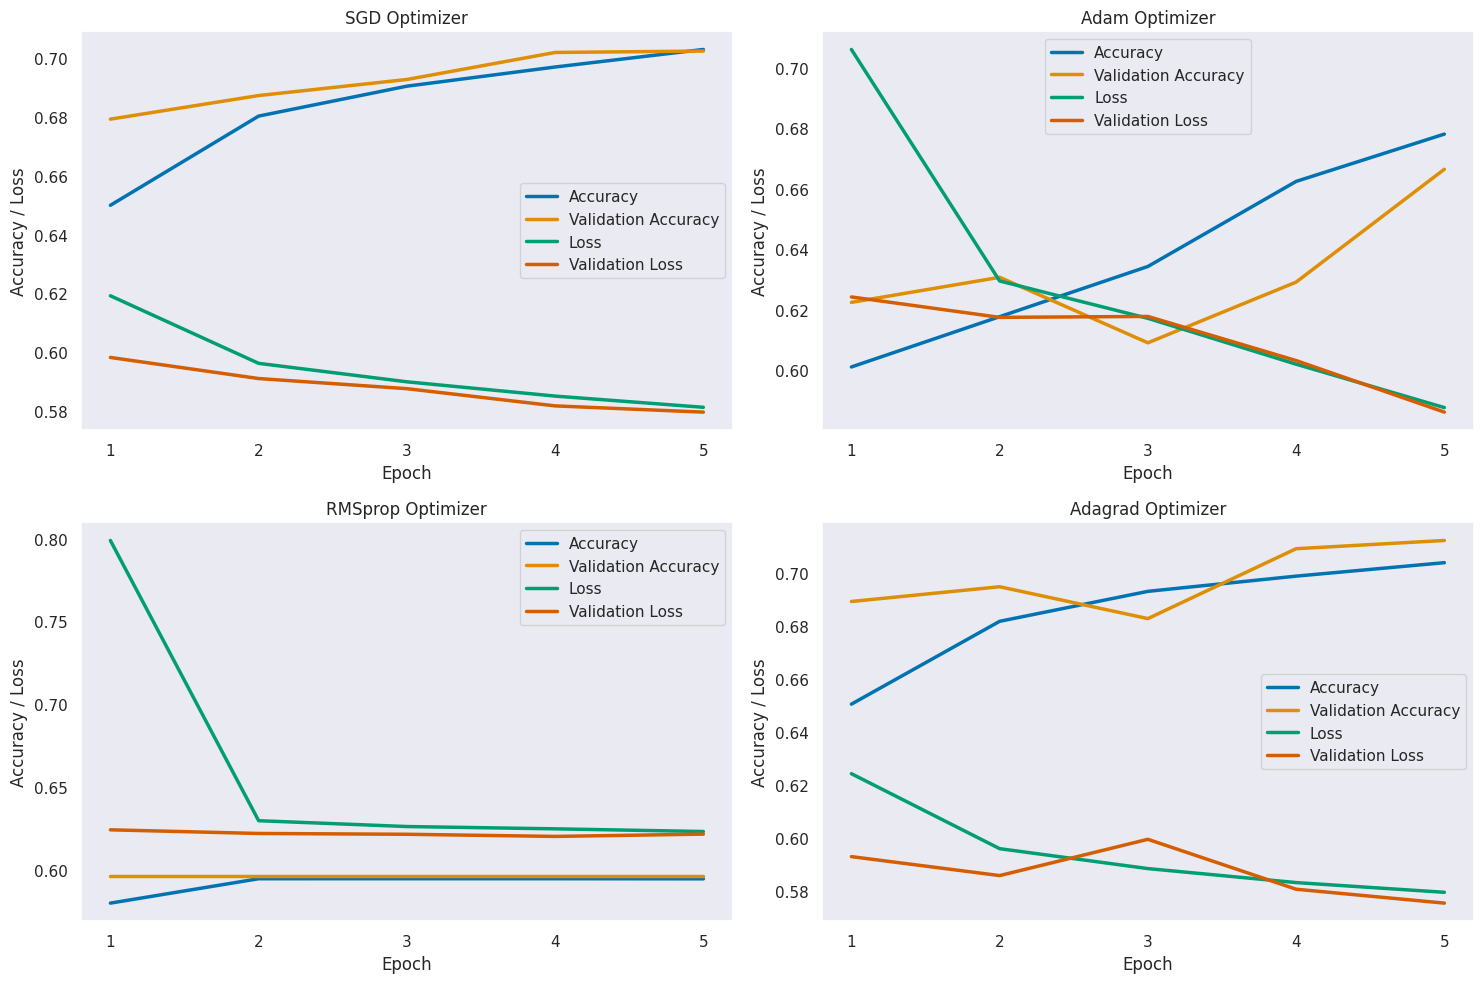

In [ ]:
# Set up subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot for SGD optimizer
axes[0, 0].plot(hist_SGD.history["accuracy"])
axes[0, 0].plot(hist_SGD.history['val_accuracy'])
axes[0, 0].plot(hist_SGD.history['loss'])
axes[0, 0].plot(hist_SGD.history['val_loss'])
axes[0, 0].set_title("SGD Optimizer")
axes[0, 0].set_ylabel("Accuracy / Loss")
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
axes[0, 0].set_xticks(range(5))  # Set the x-axis ticks to range(5)
axes[0, 0].set_xticklabels(range(1, 6))  # Set the x-axis labels to range(1, 6)

# Plot for Adam optimizer
axes[0, 1].plot(hist_Adam.history["accuracy"])
axes[0, 1].plot(hist_Adam.history['val_accuracy'])
axes[0, 1].plot(hist_Adam.history['loss'])
axes[0, 1].plot(hist_Adam.history['val_loss'])
axes[0, 1].set_title("Adam Optimizer")
axes[0, 1].set_ylabel("Accuracy / Loss")
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
axes[0, 1].set_xticks(range(5))  # Set the x-axis ticks to range(5)
axes[0, 1].set_xticklabels(range(1, 6))  # Set the x-axis labels to range(1, 6)

# Plot for RMSprop optimizer
axes[1, 0].plot(hist_RMSprop.history["accuracy"])
axes[1, 0].plot(hist_RMSprop.history['val_accuracy'])
axes[1, 0].plot(hist_RMSprop.history['loss'])
axes[1, 0].plot(hist_RMSprop.history['val_loss'])
axes[1, 0].set_title("RMSprop Optimizer")
axes[1, 0].set_ylabel("Accuracy / Loss")
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
axes[1, 0].set_xticks(range(5))  # Set the x-axis ticks to range(5)
axes[1, 0].set_xticklabels(range(1, 6))  # Set the x-axis labels to range(1, 6)

# Plot for Adagrad optimizer
axes[1, 1].plot(hist_Adagrad.history["accuracy"])
axes[1, 1].plot(hist_Adagrad.history['val_accuracy'])
axes[1, 1].plot(hist_Adagrad.history['loss'])
axes[1, 1].plot(hist_Adagrad.history['val_loss'])
axes[1, 1].set_title("Adagrad Optimizer")
axes[1, 1].set_ylabel("Accuracy / Loss")
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
axes[1, 1].set_xticks(range(5))  # Set the x-axis ticks to range(5)
axes[1, 1].set_xticklabels(range(1, 6))  # Set the x-axis labels to range(1, 6)


# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

The visualizations show that the SGD optimizer appears to have the smoothest learning over the 5 epochs (epoch 3 for Adagrad clearly had a dip in accuracy and increase in validaion loss vs the other epochs for that optimizer method). Interestingly, it seems like the Adam optimizer possibly would have overtaken the other optimizers if it was allowed to run for more epochs (possibly due to other hyperparameter choices, it needed more epochs to converge). It also appears that for the RMSprop optimizer, there wasn't much benefit to running additional epochs after the first 2 (it converged very quickly, probably too quickly).  

I quickly eliminated the RMSprop optimizer as an option, and decided that in the interest of keeping the number of epochs on the lower side (due to computaional constraints), I also would eliminate Adam as an option.

Between SGD and Adagrad, despite whatever occured during epoch 3 for Adagrad, they were similar enough that I wanted to futher explore both  optimizers before picking one.

To do this, I started tuning some additional hyperparameters. First, I added additional neurons to the network in the first Dense layer and ran the basic models again:

In [ ]:
# try higher values for density inputs
# with optimizer: SGD
SGD_model_higher = Sequential()

SGD_model_higher.add(Flatten())
SGD_model_higher.add(Dense(units = 512, activation = 'relu'))
SGD_model_higher.add(Dense(units = 1, activation = 'sigmoid'))

SGD_model_higher.build(input_shape = (batch_size, 64, 64, 3))
SGD_model_higher.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (200, 12288)              0         
                                                                 
 dense_16 (Dense)            (200, 512)                6291968   
                                                                 
 dense_17 (Dense)            (200, 1)                  513       
                                                                 
Total params: 6292481 (24.00 MB)
Trainable params: 6292481 (24.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# with optimizer: SGD
opt = SGD(learning_rate = 0.001)

SGD_model_higher.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
hist_SGD_higher = SGD_model_higher.fit(data_train, validation_data = data_validate, epochs = 5)

Epoch 1/5
881/881 [==============================] - 344s 390ms/step - loss: 0.5887 - accuracy: 0.6931 - val_loss: 0.5818 - val_accuracy: 0.7018
Epoch 2/5
881/881 [==============================] - 336s 381ms/step - loss: 0.5800 - accuracy: 0.7047 - val_loss: 0.5784 - val_accuracy: 0.7051
Epoch 3/5
881/881 [==============================] - 371s 422ms/step - loss: 0.5750 - accuracy: 0.7111 - val_loss: 0.5861 - val_accuracy: 0.6913
Epoch 4/5
881/881 [==============================] - 337s 383ms/step - loss: 0.5701 - accuracy: 0.7177 - val_loss: 0.5684 - val_accuracy: 0.7215
Epoch 5/5
881/881 [==============================] - 352s 400ms/step - loss: 0.5663 - accuracy: 0.7235 - val_loss: 0.5668 - val_accuracy: 0.7216


In [ ]:
# with optimizer: adagrad
adagrad_model_higher = Sequential()

adagrad_model_higher.add(Flatten())
adagrad_model_higher.add(Dense(units = 512, activation = 'relu'))
adagrad_model_higher.add(Dense(units = 1, activation = 'sigmoid'))

adagrad_model_higher.build(input_shape = (batch_size, 64, 64, 3))
adagrad_model_higher.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (200, 12288)              0         
                                                                 
 dense (Dense)               (200, 512)                6291968   
                                                                 
 dense_1 (Dense)             (200, 1)                  513       
                                                                 
Total params: 6292481 (24.00 MB)
Trainable params: 6292481 (24.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# with optimizer: adagrad
opt = Adagrad(learning_rate = 0.001)

adagrad_model_higher.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
hist_adagrad_higher = adagrad_model_higher.fit(data_train, validation_data = data_validate, epochs = 5)

Epoch 1/5
881/881 [==============================] - 384s 429ms/step - loss: 0.6199 - accuracy: 0.6608 - val_loss: 0.5941 - val_accuracy: 0.6932
Epoch 2/5
881/881 [==============================] - 329s 374ms/step - loss: 0.5833 - accuracy: 0.7022 - val_loss: 0.5721 - val_accuracy: 0.7125
Epoch 3/5
881/881 [==============================] - 308s 350ms/step - loss: 0.5738 - accuracy: 0.7134 - val_loss: 0.5632 - val_accuracy: 0.7245
Epoch 4/5
881/881 [==============================] - 323s 367ms/step - loss: 0.5656 - accuracy: 0.7243 - val_loss: 0.5629 - val_accuracy: 0.7308
Epoch 5/5
881/881 [==============================] - 357s 406ms/step - loss: 0.5610 - accuracy: 0.7274 - val_loss: 0.5517 - val_accuracy: 0.7414


Adding the additional neurons increased the accuacy of the model with both optimizers. I debated going up again to 1024 nuerons, but I was concerned about the additional compuational complexity vs the resources available. I decided to try tuning other hyperparameters first.


After seeing these results, I decided to move forward with the Adagrad optimizer method, since it does seem to be slightly outperforming SGD in terms of accuracy.


The next step I took to turn the model was to add some additional layers to the model to try to further improve accuracy. Instead of adding additional Dense latyers, I added some convolution layers (starting with size 32 and 64, since the problem statement specifies that the goal is to identify tumors in 32x32 patches, and I increased the size to 64x64 when I created the train and validate split). And a maxpooling layer for each convolutional layer to reduce dimsnionality.


I'm also going to increase the learning rate to see if convergence can be sped up without causing ecessesive instability, finally, I'm going to lower batch size to 100 to allow for better generalization.

In [ ]:
# now with optimizer chosen, add more layers

model_v2 = Sequential()

# Convolutional layers
model_v2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model_v2.add(MaxPooling2D((2, 2)))

model_v2.add(Conv2D(64, (3, 3), activation='relu'))
model_v2.add(MaxPooling2D((2, 2)))

# Flatten and Dense layers
model_v2.add(Flatten())
model_v2.add(Dense(units=512, activation='relu'))
model_v2.add(Dense(units=1, activation='sigmoid'))

# Build the model
model_v2.build(input_shape=(batch_size, 64, 64, 3))
model_v2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 12544)             0         
                                                                 
 dense_2 (Dense)             (None, 512)              

I also lowered the batch size and increased the learning rate to see if I could improve the ability of the model to generalize from the training data.

In [ ]:
# updated learning rate and batch size
opt = Adagrad(learning_rate = 0.01)
batch_size = 75

model_v2.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
hist_model_v2 = model_v2.fit(data_train, validation_data = data_validate, epochs = 5)

Epoch 1/5
881/881 [==============================] - 360s 401ms/step - loss: 0.5129 - accuracy: 0.7506 - val_loss: 0.4768 - val_accuracy: 0.7801
Epoch 2/5
881/881 [==============================] - 366s 416ms/step - loss: 0.4537 - accuracy: 0.7927 - val_loss: 0.4419 - val_accuracy: 0.7983
Epoch 3/5
881/881 [==============================] - 364s 413ms/step - loss: 0.4375 - accuracy: 0.8014 - val_loss: 0.4245 - val_accuracy: 0.8110
Epoch 4/5
881/881 [==============================] - 393s 446ms/step - loss: 0.4224 - accuracy: 0.8095 - val_loss: 0.4202 - val_accuracy: 0.8125
Epoch 5/5
881/881 [==============================] - 354s 402ms/step - loss: 0.4115 - accuracy: 0.8151 - val_loss: 0.4034 - val_accuracy: 0.8199


The additional layers improved accuracy in both the training and validation sets, but not by much. I decided to add additional convlultion layers (one smaller and one larger) to see if they helped. Finally, I added batch normaliztion as well, as this can be another technique that improves the accuracy of CNN models:


In [ ]:
# add batch norming and additional convolutional layers
model_v3 = Sequential()

# Convolutional layers
model_v3.add(Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model_v3.add(BatchNormalization())
model_v3.add(MaxPooling2D((2, 2)))

model_v3.add(Conv2D(32, (3, 3), activation='relu'))
model_v3.add(BatchNormalization())
model_v3.add(MaxPooling2D((2, 2)))

model_v3.add(Conv2D(64, (3, 3), activation='relu'))
model_v3.add(BatchNormalization())
model_v3.add(MaxPooling2D((2, 2)))

model_v3.add(Conv2D(128, (3, 3), activation='relu'))
model_v3.add(BatchNormalization())
model_v3.add(MaxPooling2D((2, 2)))

# Flatten and Dense layers
model_v3.add(Flatten())
model_v3.add(Dense(units=512, activation='relu'))
model_v3.add(Dense(units=1, activation='sigmoid'))

# Build the model
model_v3.build(input_shape=(batch_size, 64, 64, 3))
model_v3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 batch_normalization (Batch  (None, 62, 62, 16)        64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 32)        128       
 chNormalization)                                                
                                                        

For this version of the model, I also increased the number of epochs from 5 to 10 to see how tuning that hyperparameter changed my results.

In [ ]:
# increased number of epochs
opt = Adagrad(learning_rate = 0.01)
batch_size = 75

model_v3.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
hist_model_v3 = model_v3.fit(data_train, validation_data = data_validate, epochs = 10)

Epoch 1/10
881/881 [==============================] - 363s 408ms/step - loss: 0.3946 - accuracy: 0.8238 - val_loss: 0.3814 - val_accuracy: 0.8314
Epoch 2/10
881/881 [==============================] - 355s 403ms/step - loss: 0.3425 - accuracy: 0.8503 - val_loss: 0.3491 - val_accuracy: 0.8485
Epoch 3/10
881/881 [==============================] - 374s 424ms/step - loss: 0.3188 - accuracy: 0.8631 - val_loss: 0.3454 - val_accuracy: 0.8503
Epoch 4/10
881/881 [==============================] - 347s 394ms/step - loss: 0.3015 - accuracy: 0.8720 - val_loss: 0.3189 - val_accuracy: 0.8652
Epoch 5/10
881/881 [==============================] - 346s 393ms/step - loss: 0.2849 - accuracy: 0.8798 - val_loss: 0.3034 - val_accuracy: 0.8710
Epoch 6/10
881/881 [==============================] - 343s 390ms/step - loss: 0.2711 - accuracy: 0.8860 - val_loss: 0.3139 - val_accuracy: 0.8673
Epoch 7/10
881/881 [==============================] - 363s 412ms/step - loss: 0.2575 - accuracy: 0.8933 - val_loss: 0.3084 -

This model has an accuracy of over 90% on the training data and is close to 90% accurate on the validation set. This accuracy level seems like a good canidate to use as my final model to use on the test dataset. While there might be additional tuning steps that could improve it, there's also increased risk of overfiting.



### Results/Conclusion

I vizualized the results of this model to check for overfitting or other probelms:

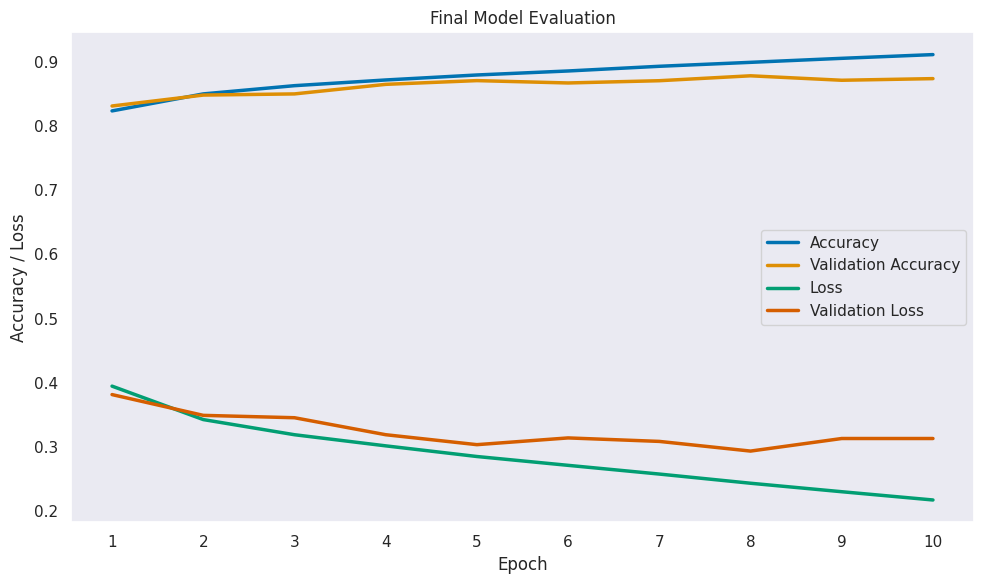

In [ ]:
# evaluate final modal
plt.figure(figsize=(10, 6))

plt.plot(hist_model_v3.history["accuracy"])
plt.plot(hist_model_v3.history['val_accuracy'])
plt.plot(hist_model_v3.history['loss'])
plt.plot(hist_model_v3.history['val_loss'])

plt.title("Final Model Evaluation")
plt.ylabel("Accuracy / Loss")
plt.xlabel("Epoch")
plt.legend(["Accuracy", "Validation Accuracy", "Loss", "Validation Loss"])
plt.xticks(range(10), range(1, 11))  # Set the x-axis ticks and labels
plt.tight_layout()

# Show the plot
plt.show()

The fact that the validaion loss starts rising in the last 2 epochs is a little concerning (this can indicate overfitting, or that the model is overly complex or other issues), but in this case I think the increase is small enough not to be an issues. I probably would need to perform many more iterations with different hyperparameter values to determine if I could eliminate that small increase (or increase my overall model accuracy in general).  It's also possible that increasing the epoch number wasn't necessary and sticking with 5 (or doing a small increase to 7 instead of 10) would have been sufficient.

I applied my firnal model to the test data and generated a submission file to submit to Kaggle.

In [ ]:
# to submit:
generator_test = ImageDataGenerator(rescale=1./255)

# generate test data
data_test = generator_test.flow_from_dataframe(
    directory = test_dir,
    dataframe = images_test,
    x_col ='id',
    class_mode=None,
    batch_size = 5,
    target_size = (64, 64),
    shuffle=False)

# apply the final model to the test data
predictions = model_v3.predict(data_test, verbose=1)

# reformat the output of aplying the model
pred = np.transpose(predictions)[0]

# create the submission file
submission = pd.DataFrame()
submission['id'] = images_test['id'].apply(lambda x: x.split('.')[0])
submission['label'] = list(map(lambda x: 0 if x < 0.5 else 1, pred))
submission.to_csv('submission.csv', index=False)

Found 57458 validated image filenames.
11492/11492 [==============================] - 202s 18ms/step


My private score was 0.79 and my public score was 0.84. This indicates that my final model was 80-85% accurate when applied to the test data.

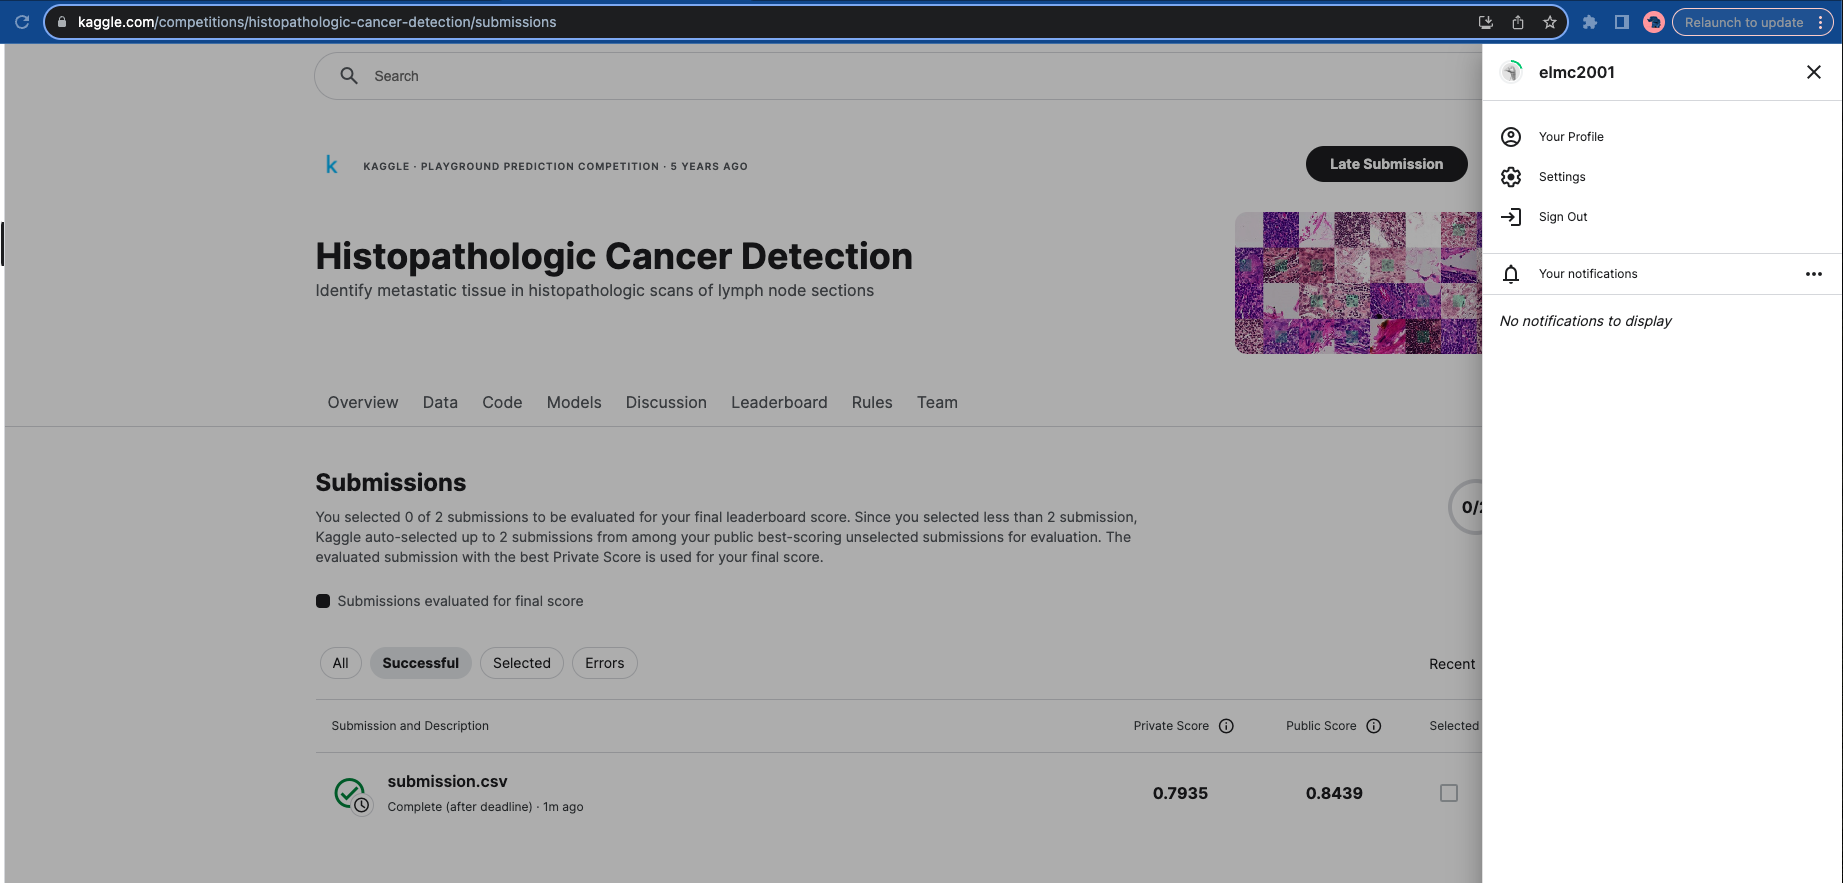

This score indicates to me that I did a reasonable job of tuning my model, but there is room for further improvement. To develop my model, I iterativly tuned my optimizer selection, number of neurons, number and type of layers, learning rate, batch size and number of epochs. Ideally, I would try additional hyperparameter tuning procedures (either changing one or 2 at a time like I did to develop this model or using a more automated approach such as KerasTuner, or trying some of the optimizer specific inputs, such as using more finely controled weights and/or some of the moving average options). It also may have been a better stratey to try to do more tuning iterations on fewer different hyperparameters (such as concentrating on just changing the learning rate and batch size but trying 5 different values for each one).  My approach allowed me to take a look at a lot of different hyperparameters, but not explore any one of them in great depth.


It's clear to me that tuning takes a potentially large number of iterations and in this investigation, I only scratched the surface of what it's possible to iterate through. But, those iterations can also potentially take a great deal of time and computing resources to work through. It's important to balance additional accuracy vs that time/allocation. For example, I used my simplest model to pick an optimizer. It would be interesting to investigate if my optimizer choice would change if I performed that step later in the process, when the model was more complex.


It's also possible that futher tuning of my model could only improve it so much without needing to potentially make significant architechtual changes. I think that's one of the more difficult tasks in tuning models: how good is good enough? At what point have you reached the point of diminishing returns and further iteration isn't benefiting your outcome enough to justify the resources being put into it?


Is a model that can detect 85% of tumors automatically supperior to one that can detect 84% of tumors? What if the model with the higher accuracy takes 6 times longer to run? Or takes 4 times the computational resources? If you have the 1% tumor that is missed by my hypothetical faster/simplier/slightly less accurate model, the answer is probably easy: the more accurate model is better. But the reality is more complex and highly sitatuional.


Missing a tumor might mean the patient has a delayed start to treatment which potentially leads to a worse outcome. Doing an image search of the photos on your phone to find all the ones that have a dog in them has lower stakes and is a case where speed is much more important than accuracy - you probably don't mind if it misses a few or includes a few pictures in the results that don't actually have a dog in them. It's important to not only understand the mechanics of how to tune a deep learning model, but also the context of what the model will be used for in order to make more informed decisions about what aspects to prioritize (speed, accuracy, computaitonal complexity, etc. )

Github url: https://github.com/emcdowell-cu/CSPB3202/blob/main/HW5.ipynb